# Apêndice A

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr"

In [2]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
import uuid


In [3]:
BASE_PATH = ['../..','datasets']

DATASET_DIR = os.path.join(BASE_PATH[0],BASE_PATH[1],'PKLot')

path = '/PKLot/UFPR05/todas'
vagas = 37
pontos = vagas*4
path = os.path.normpath(path)
path = path.split(os.sep)

IMAGE_DIR = os.path.join(DATASET_DIR,path[2],path[3])
XML_DIR = IMAGE_DIR
SAVE_DIR = os.path.join(DATASET_DIR,path[2])

IMAGE_PATH = []
XML_PATH = []
def criarLista():
    for file in os.listdir(IMAGE_DIR):
        if file.endswith(".jpg"):

            file = os.path.join(IMAGE_DIR,file)
            IMAGE_PATH.append(file)
    IMAGE_PATH.sort()

    for file in os.listdir(IMAGE_DIR):
        if file.endswith(".xml"):

            file = os.path.join(XML_DIR,file)
            XML_PATH.append(file)
    XML_PATH.sort()


criarLista()
#debug
print(IMAGE_DIR)
print(SAVE_DIR)
print(IMAGE_PATH[:2])
print(XML_PATH[:2])

../../datasets/PKLot/UFPR05/todas
../../datasets/PKLot/UFPR05
['../../datasets/PKLot/UFPR05/todas/2013-02-22_06_05_00.jpg', '../../datasets/PKLot/UFPR05/todas/2013-02-22_06_10_00.jpg']
['../../datasets/PKLot/UFPR05/todas/2013-02-22_06_05_00.xml', '../../datasets/PKLot/UFPR05/todas/2013-02-22_06_10_00.xml']


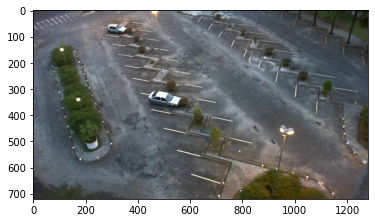

In [4]:
image = plt.imread(IMAGE_PATH[0])
plt.imshow(image)

## Carrega o XML e filtra os pontos X e Y.

In [5]:
tree = ET.parse(XML_PATH[0])
root = tree.getroot()

pts = np.empty(0,np.int32)
vaga = np.empty(0,np.int32)

for neighbor in root.iter('point'):
    #print(neighbor.attrib)
    x,y = neighbor.attrib.values()
    x = int(x)
    y = int(y)
    a = [x,y]
    pts = np.append(pts,[x,y])
    
for neighbor in root.iter('space'):
    #print(neighbor.attrib)
    if(len(neighbor.attrib.values())==2):
        _,occupied = neighbor.attrib.values()
        occupied = int(occupied)
    if(len(neighbor.attrib.values())==1):
        occupied=0
        
    vaga = np.append(vaga,occupied)

#debug
print(pts[0:4])
print(vaga[0:vagas])

[608 613 741 654]
[0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


## Organiza os pares XY de cada Ponto.

In [6]:
paresXY = np.array(np.zeros((pontos,2)),np.int32) 
j=0
for i in range(pontos):
    paresXY[i] = pts[j:j+2]
    j = j+2

#debug
paresXY[0:4]

array([[608, 613],
       [741, 654],
       [775, 582],
       [608, 526]], dtype=int32)

## CROP (Função que segmenta e salva as imagens segmentadas)

In [7]:
def crop(j=0,i=0,vaga=2,lista=5):
    rect = cv2.boundingRect(paresXY[j:j+4])
    x,y,w,h = rect
    croped = im2[y:y+h, x:x+w].copy()

    pts = paresXY[j:j+4] - paresXY[j:j+4].min(axis=0)
    mask = np.zeros(croped.shape[:2], croped.dtype)
    cv2.drawContours(mask, [pts], -1, (255, 255, 255), -1, cv2.LINE_AA)

    ## (3) do bit-op
    dst = cv2.bitwise_and(croped, croped, mask=mask) #background preto

    bg = np.ones_like(croped, np.uint8)*255
    cv2.bitwise_not(bg,bg, mask=mask)
    dst2 = bg+ dst #background branco
    
    image = cv2.resize(dst2, (128,128), interpolation = cv2.INTER_CUBIC)
    arquivo = 'vaga{}_ocupado{}_{}.jpg'.format(i,vaga,lista)
    
    path=os.path.join(SAVE_DIR,'output')
    if not os.path.exists(path):
        os.makedirs(path)
    
    path = os.path.join(SAVE_DIR,'output','livre')
    if not os.path.exists(path):
        os.makedirs(path)
    
    path = os.path.join(SAVE_DIR,'output','ocupada')
    if not os.path.exists(path):
        os.makedirs(path)
    
    if vaga:
        path=os.path.join(SAVE_DIR,'output','ocupada',arquivo)
        cv2.imwrite(path, image)
        
    else:
        path=os.path.join(SAVE_DIR,'output','livre',arquivo)
        cv2.imwrite(path, image) 

## Cria as delimitações a partir dos pontos do XML
## Exibe a imagem completa com as segmentações
## Chama a função crop para cada vaga delimitada


<img src="./images/output.png" alt="Pasta output" width=300 height=240>

## CROP DA LISTA

In [8]:
%%time

for lista in range (0,len(IMAGE_PATH),2):

    #PARTE 1

    tree = ET.parse(XML_PATH[lista])
    root = tree.getroot()

    pts = np.empty(0,np.int32)
    vaga = np.empty(0,np.int32)

    for neighbor in root.iter('point'):
        x,y = neighbor.attrib.values()
        x = int(x)
        y = int(y)
        a = [x,y]
        pts = np.append(pts,[x,y])

    for neighbor in root.iter('space'):
        if(len(neighbor.attrib.values())==2):
            _,occupied = neighbor.attrib.values()
            occupied = int(occupied)
        if(len(neighbor.attrib.values())==1):
            occupied=0

        vaga = np.append(vaga,occupied)


    #PARTE 2


    paresXY = np.array(np.zeros((pontos,2)),np.int32) 
    j=0
    for i in range(pontos):
        paresXY[i] = pts[j:j+2]
        j = j+2

    #PARTE 3


    im = cv2.imread(IMAGE_PATH[lista])
    im2 = im.copy()
    if im is None:
        sys.exit("A imagem não foi carregada.")

    j=0
    for i in range(len(paresXY)//4):
        cv2.polylines(im,[paresXY[j:j+4]],True,(0,255,255),2)
        crop(j,i,vaga[i],lista)
        j=j+4

CPU times: user 1min 2s, sys: 2.66 s, total: 1min 5s
Wall time: 1min 5s
